In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, 
import tensorflow as tf
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import os
print(os.listdir("../input"))
import glob
from tqdm import tqdm
import cv2
from PIL import ImageDraw,Image
traindf=pd.read_csv('../input/training/training.csv')
testdf=pd.read_csv('../input/test/test.csv')
from keras.layers.advanced_activations import LeakyReLU

['test', 'IdLookupTable.csv', 'SampleSubmission.csv', 'training']


Using TensorFlow backend.


In [2]:
columns=[i for i in traindf.columns if 'eye_center' in i or 'nose' in i or'bottom_lip' in i]

In [3]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [4]:
traindf.shape

(7049, 31)

In [5]:
X_train=np.stack([np.array(list(map(int,i.split(" ")))).reshape((96,96)) for i in traindf.Image])
X_test=np.stack([np.array(list(map(int,i.split(" ")))).reshape((96,96)) for i in testdf.Image])



In [6]:
img=X_train[16].astype(np.float32)
m=traindf.loc[2,columns]

In [7]:
m

left_eye_center_x            65.0571
left_eye_center_y            34.9096
right_eye_center_x           30.9038
right_eye_center_y           34.9096
nose_tip_x                   47.5573
nose_tip_y                   53.5389
mouth_center_bottom_lip_x    47.2749
mouth_center_bottom_lip_y    78.6594
Name: 2, dtype: object

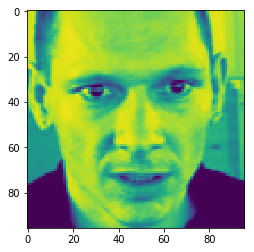

In [8]:
a=Image.fromarray(img)
draw=ImageDraw.Draw(a)
plt.imshow(a)

In [9]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)

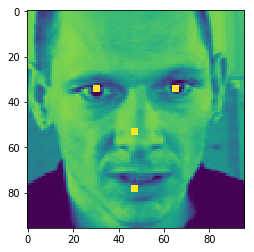

In [10]:
plt.imshow(a)

In [11]:
X_train1=X_train.astype(np.float32)/255

In [12]:
Ytrain=traindf.loc[:,columns]
    


In [13]:
X_train1.shape

(7049, 96, 96)

In [14]:
indexes=Ytrain[pd.isna(Ytrain).any(axis=1)].index


In [15]:
X=np.delete(X_train1,indexes,axis=0)

In [16]:
X.shape

(7000, 96, 96)

In [17]:
Y=Ytrain.dropna(axis=0)


In [18]:
Y.shape

(7000, 8)

In [19]:
Y=Y.values

In [20]:
Y=Y.astype(np.float32)

In [21]:
Y.shape

(7000, 8)

In [22]:
X.shape

(7000, 96, 96)

In [23]:
X=X.reshape((-1,96,96,1))

In [24]:
X.shape

(7000, 96, 96, 1)

In [25]:
#Making Model
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,BatchNormalization,InputLayer
from keras.models import Model,Sequential

In [26]:
model=Sequential()
model.add(InputLayer((96,96,1)))
model.add(Conv2D(16,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Conv2D(128,kernel_size=(3,3),padding='same'))
model.add(BatchNormalization())
model.add(Activation(LeakyReLU(0.2)))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(8))                     # Mistake fixed removed softmax since we are not normalizing the probability its a regression 
model.compile(loss='mse',optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


/opt/conda/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 96, 96, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 48, 48, 32)        0         
__________

In [28]:
history = model.fit(X,Y,epochs=100,batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
7000/7000 [==============================] - 5s 748us/step - loss: 152.8251
Epoch 2/100
7000/7000 [==============================] - 2s 308us/step - loss: 10.6934
Epoch 3/100
7000/7000 [==============================] - 2s 308us/step - loss: 8.3467
Epoch 4/100
7000/7000 [==============================] - 2s 308us/step - loss: 7.0576
Epoch 5/100
7000/7000 [==============================] - 2s 310us/step - loss: 6.2082
Epoch 6/100
7000/7000 [==============================] - 2s 309us/step - loss: 5.7703
Epoch 7/100
7000/7000 [==============================] - 2s 309us/step - loss: 5.1544
Epoch 8/100
7000/7000 [==============================] - 2s 308us/step - loss: 4.7792
Epoch 9/100
7000/7000 [==============================] - 2s 308us/step - loss: 4.3984
Epoch 10/100
7000/7000 [==============================] - 2s 309us/step - loss: 4.2452
Epoch 11/100
7000/7000 [==============================] - 2s 328us/step - loss: 3.8733
E

In [29]:
Xtest1=X_test[0:10].astype(np.float32)/255
Xtest1=Xtest1.reshape((-1,96,96,1))

In [30]:
ypred=model.predict(Xtest1)

In [31]:
ypred

array([[67.39562 , 39.0062  , 31.443048, 37.50885 , 49.847736, 53.274696,
        49.28244 , 87.38041 ],
       [68.928696, 37.759937, 28.357513, 37.63466 , 50.182964, 61.77204 ,
        50.864555, 90.98365 ],
       [67.85002 , 38.396885, 31.669622, 39.365356, 50.327377, 57.988464,
        51.152576, 88.00627 ],
       [67.628204, 40.489445, 32.75221 , 41.197083, 48.912144, 54.412525,
        51.217407, 85.56657 ],
       [68.82126 , 37.832886, 30.103886, 39.626537, 49.502625, 54.53651 ,
        51.507614, 89.22704 ],
       [69.919174, 38.317722, 30.138264, 37.726482, 48.96931 , 55.049103,
        50.956726, 89.33217 ],
       [68.34387 , 34.518078, 27.936028, 35.02265 , 52.87366 , 57.46958 ,
        51.97361 , 86.86801 ],
       [69.75228 , 37.54036 , 31.46669 , 37.534363, 51.475063, 56.01447 ,
        52.24051 , 84.374825],
       [66.13408 , 40.859524, 32.647644, 39.335247, 49.274044, 60.826008,
        49.77149 , 87.54742 ],
       [68.970825, 37.473087, 32.37846 , 37.446526, 50.

In [32]:
m=ypred[0]
xtest1=Xtest1[0].astype(np.float32)*255.0       # have to multiply image with 255 otherwise image is shown to be black
xtest1=xtest1.reshape((96,96))

In [33]:
a=Image.fromarray(xtest1)
draw=ImageDraw.Draw(a)

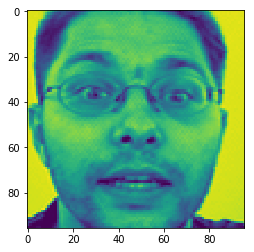

In [34]:
plt.imshow(xtest1)

In [35]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)

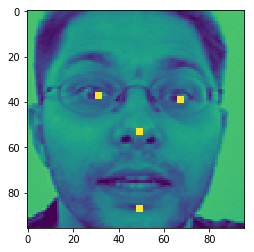

In [36]:
plt.imshow(a)  # with MSE  worked good

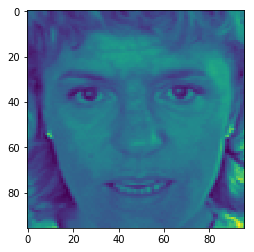

In [37]:
m=ypred[1]
xtest1=Xtest1[1].astype(np.float32)*255.0       # have to multiply image with 255 otherwise image is shown to be black
xtest1=xtest1.reshape((96,96))
a=Image.fromarray(xtest1)
draw=ImageDraw.Draw(a)
plt.imshow(xtest1)

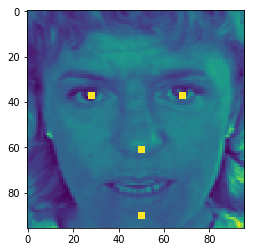

In [38]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)
    
plt.imshow(a) 

In [39]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [40]:
columns=[i for i in traindf.columns if 'eyebrow' in i or 'corner' in i or 'top_lip' in i]

In [41]:
columns

['left_eye_inner_corner_x',
 'left_eye_inner_corner_y',
 'left_eye_outer_corner_x',
 'left_eye_outer_corner_y',
 'right_eye_inner_corner_x',
 'right_eye_inner_corner_y',
 'right_eye_outer_corner_x',
 'right_eye_outer_corner_y',
 'left_eyebrow_inner_end_x',
 'left_eyebrow_inner_end_y',
 'left_eyebrow_outer_end_x',
 'left_eyebrow_outer_end_y',
 'right_eyebrow_inner_end_x',
 'right_eyebrow_inner_end_y',
 'right_eyebrow_outer_end_x',
 'right_eyebrow_outer_end_y',
 'mouth_left_corner_x',
 'mouth_left_corner_y',
 'mouth_right_corner_x',
 'mouth_right_corner_y',
 'mouth_center_top_lip_x',
 'mouth_center_top_lip_y']

In [42]:
#Eye /eyebrow /mouth classifier
Y=traindf.loc[:,columns]

In [43]:
indexes=Y[pd.isna(Y).any(axis=1)].index

In [44]:
Xtrain3=np.delete(X_train1,indexes,axis=0)

In [45]:
Xtrain3.shape

(2155, 96, 96)

In [46]:
Y=Y.dropna(axis=0)

In [47]:
Y.shape

(2155, 22)

In [48]:
x1=Xtrain3[1]*255
m=Y.iloc[1,:]

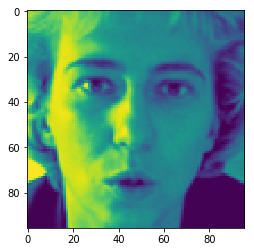

In [49]:
plt.imshow(x1)

In [50]:
x1=Image.fromarray(x1)
draw=ImageDraw.Draw(x1)
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)

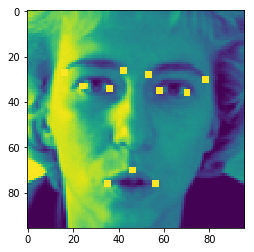

In [51]:
plt.imshow(x1)

In [52]:
Xtrain3=Xtrain3.astype(np.float32)

In [53]:
Xtrain3.shape

(2155, 96, 96)

In [54]:
Xtrain3=Xtrain3.reshape((-1,96,96,1))

In [55]:
Y=Y.values
Y=Y.astype(np.float32)

In [56]:
Y.shape

(2155, 22)

In [57]:
model1=Sequential()
model1.add(InputLayer((96,96,1)))
model1.add(Conv2D(16,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(32,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Conv2D(128,kernel_size=(3,3),padding='same'))
model1.add(BatchNormalization())
model1.add(Activation(LeakyReLU(0.2)))
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(22))                     # Mistake fixed removed softmax since we are not normalizing the probability its a regression 
model1.compile(loss='mse',optimizer='adam')

/opt/conda/lib/python3.6/site-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [58]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 16)        160       
_________________________________________________________________
batch_normalization_6 (Batch (None, 96, 96, 16)        64        
_________________________________________________________________
activation_6 (Activation)    (None, 96, 96, 16)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 48, 48, 32)        4640      
_________________________________________________________________
batch_normalization_7 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 48, 48, 32)        0         
__________

In [59]:
history = model1.fit(Xtrain3,Y,epochs=100,batch_size=32)

Epoch 1/100
2155/2155 [==============================] - 2s 777us/step - loss: 488.3494
Epoch 2/100
2155/2155 [==============================] - 1s 310us/step - loss: 9.5545
Epoch 3/100
2155/2155 [==============================] - 1s 310us/step - loss: 8.1618
Epoch 4/100
2155/2155 [==============================] - 1s 313us/step - loss: 6.8558
Epoch 5/100
2155/2155 [==============================] - 1s 310us/step - loss: 5.5797
Epoch 6/100
2155/2155 [==============================] - 1s 311us/step - loss: 4.5846
Epoch 7/100
2155/2155 [==============================] - 1s 312us/step - loss: 3.9170
Epoch 8/100
2155/2155 [==============================] - 1s 313us/step - loss: 3.6008
Epoch 9/100
2155/2155 [==============================] - 1s 310us/step - loss: 3.1719
Epoch 10/100
2155/2155 [==============================] - 1s 316us/step - loss: 2.9648
Epoch 11/100
2155/2155 [==============================] - 1s 310us/step - loss: 2.7324
Epoch 12/100
2155/2155 [==========================

In [60]:
Xtest1.shape

(10, 96, 96, 1)

In [61]:
ypred=model1.predict(Xtest1)

In [62]:
x=Xtest1[5].reshape((96,96))*255

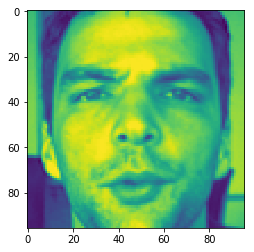

In [63]:
plt.imshow(x)

In [64]:
m=ypred[5]

In [65]:
m

array([59.459698, 37.215103, 75.220245, 39.34993 , 36.639393, 37.42699 ,
       20.871418, 40.138435, 55.31454 , 30.52356 , 80.32416 , 29.83986 ,
       40.465042, 30.118616, 15.616827, 30.439651, 65.316246, 75.02322 ,
       32.198566, 75.81709 , 48.2882  , 71.17067 ], dtype=float32)

In [66]:
x1=Image.fromarray(x)

In [67]:
draw=ImageDraw.Draw(x1)

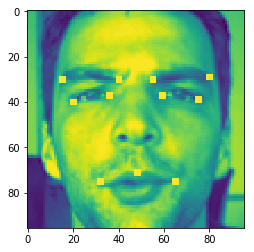

In [68]:
for i in range(len(m)//2):
    if i==len(m)-1:
        continue
    draw.ellipse((m[2*i]-1,m[2*i+1]-1,m[2*i]+1,m[2*i+1]+1),fill=255)
    
plt.imshow(x1) 

In [69]:
df=pd.read_csv('../input/IdLookupTable.csv')

In [70]:
df

,RowId,ImageId,FeatureName,Location
0,1,1,left_eye_center_x,NaN
1,2,1,left_eye_center_y,NaN
2,3,1,right_eye_center_x,NaN
3,4,1,right_eye_center_y,NaN
4,5,1,left_eye_inner_corner_x,NaN
5,6,1,left_eye_inner_corner_y,NaN
6,7,1,left_eye_outer_corner_x,NaN
7,8,1,left_eye_outer_corner_y,NaN
8,9,1,right_eye_inner_corner_x,NaN
9,10,1,right_eye_inner_corner_y,NaN


In [71]:
traindf.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')